# Top 10 Statistics Mistakes Made by Data Scientists - Examples Code

Blog post available at https://github.com/d6t/d6t-python/blob/master/blogs/top10-mistakes-statistics.md

In [1]:
# calc
import pandas as pd
import numpy as np
import scipy.stats

# viz
import seaborn as sns
from matplotlib import pyplot as plt

# ML
import sklearn.model_selection
import sklearn.metrics
from sklearn.metrics import mean_squared_error as sklmse

In [2]:
# helpers
def print2(a,b,ta=None,tb=None):
    print(ta,np.round(a,3),tb,np.round(b,3))

def CVTestMean(model, dfg):
    return -sklearn.model_selection.cross_validate(model,dfg.iloc[:,:-1],dfg.iloc[:,-1], cv=10, scoring='neg_mean_squared_error')['test_score'].mean()

def mse(model, dfg):
     return sklearn.metrics.mean_squared_error(model.predict(dfg.iloc[:,:-1]),dfg.iloc[:,-1])

## Load data

The code uses workflow management library [d6tflow](https://github.com/d6t/d6tflow) and data is shared with dataset management library [d6tpipe](https://github.com/d6t/d6tpipe).

In [3]:
import d6tflow.pipes
d6tflow.pipes.init('top10-mistakes-stats')
d6tflow.pipes.get_pipe().pull()

Welcome to d6tflow!
Welcome to d6tpipe!
Connected to https://pipe.databolt.tech as citynorman
Successfully connected to pipe top10-mistakes-stats. 
pulling: 0.00MB


0it [00:00, ?it/s]


[]

In [4]:
import cfg, tasks

## Example 1

In [5]:
# objective function
from sklearn.metrics import f1_score, accuracy_score
y_true = [0, 0, 0, 0, 0]
y_pred = [0, 1, 0, 1, 0]
y_true = np.tile(y_true,10)+[1]
y_pred = np.tile(y_pred,10)+[0]

print2(f1_score(y_true,y_pred), accuracy_score(y_true,y_pred), 'f1', 'accuracy')

f1 0.571 accuracy 0.4


## Example 2

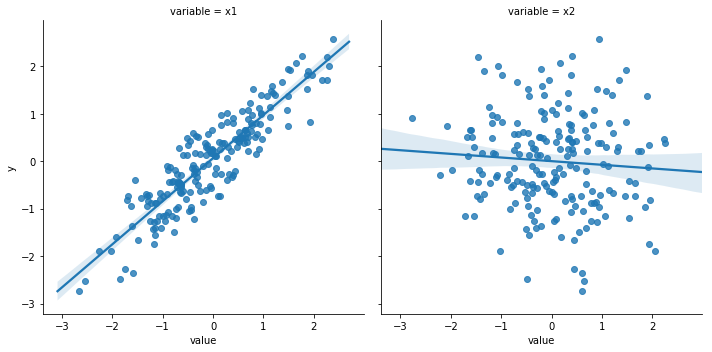

In [6]:
df = tasks.DataRegression().outputLoad()
dfp = df.melt(value_vars=['x1','x2'],id_vars='y')
sns.lmplot(x="value", y="y", col="variable", data=dfp)
plt.savefig('reports/top10-stats-example2.png')

## Example 3

slope x1 w/o outlier 0.906 slope w/ outlier -0.375


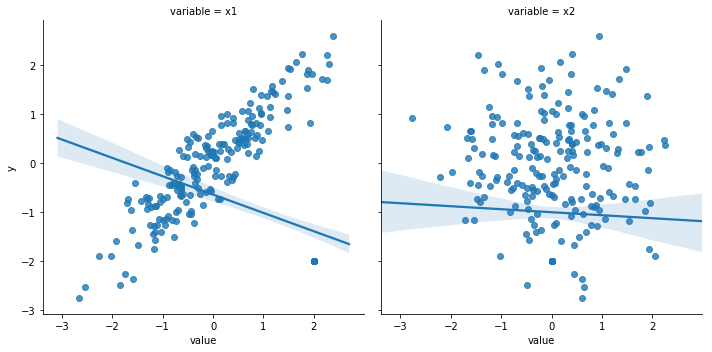

In [7]:
df = tasks.DataOutliers().outputLoad()
m1, m2 = tasks.ModelOutliers().outputLoad()
dfp = df.melt(value_vars=['x1','x2'],id_vars='y')
sns.lmplot(x="value", y="y", col="variable", data=dfp)
plt.savefig('reports/top10-stats-example3.png')
print2(m1.coef_[0],m2.coef_[0], 'slope x1 w/o outlier', 'slope w/ outlier')

## Example 4

In [8]:
df_ts = tasks.DataTS().outputLoad()
m1, m2 = tasks.ModelTS().outputLoad()
print('ols CV mse',round(CVTestMean(m1,df_ts),3))
print('rf CV mse', round(CVTestMean(m2,df_ts),3))
print('last out-sample mse', round(sklmse(df_ts.iloc[1:,-1],df_ts['y'].shift().dropna()),3))

ols CV mse 0.215
rf CV mse 0.428
last out-sample mse 0.003


## Example 5

In [9]:
df = tasks.DataRegression().outputLoad()
m1, m2 = tasks.OLSvsRF().outputLoad()
print('in-sample')
print2(mse(m2, df),mse(m1, df),'rf mse','ols mse')
print('out-sample')
print2(CVTestMean(m2,df),CVTestMean(m1,df),'rf mse','ols mse')


in-sample
rf mse 0.04 ols mse 0.183
out-sample
rf mse 0.261 ols mse 0.187


## Example 6

In [10]:
df = tasks.DataRegression().outputLoad()
m1, m2 = tasks.OLSvsRF().outputLoad()

# mixing training and test data
df_insample = pd.DataFrame(scipy.stats.zscore(df.copy())) # everything just became training data!

# better
X=df.iloc[:,:-1]; y=df.iloc[:,-1];test_error=[]
for train_index, test_index in sklearn.model_selection.KFold(n_splits=10).split(df):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    X_train, X_test = scipy.stats.zscore(X.iloc[train_index]), scipy.stats.zscore(X.iloc[test_index])
    y_train, y_test = scipy.stats.zscore(y.iloc[train_index]), scipy.stats.zscore(y.iloc[test_index])
    m1.fit(X_train,y_train)
    test_error.append(sklmse(y_test,m1.predict(X_test)))
 # => distributional properties haven't changed

print2(CVTestMean(m1,df_insample),np.mean(test_error),'mixed out-sample CV mse','true out-sample CV mse')

mixed out-sample CV mse 0.187 true out-sample CV mse 0.181


## Example 7

In [11]:
df_ts = tasks.DataTS().outputLoad().reset_index(drop=True).sort_index()
df_ts = pd.concat([df_ts,df_ts]) # data for two entities which are highly correlated, in this case identical

# default CV
m1 = sklearn.linear_model.LinearRegression()
m2 = sklearn.ensemble.RandomForestRegressor(n_estimators=10)
print('normal CV')
print2(CVTestMean(m1,df_ts),CVTestMean(m2,df_ts),'ols','rf')

# roll-forward testing
mroll = sklearn.linear_model.LinearRegression()
mroll2 = sklearn.ensemble.RandomForestRegressor(n_estimators=10)
pred_ols = []; pred_rf = [];
for i in range(cfg.nobs//3,df.shape[0]):
    x_train = df.iloc[:i-1,:-1]
    y_train = df.iloc[:i-1,-1]
    x_test = df.iloc[i,:-1]
    mroll.fit(x_train,y_train)
    mroll2.fit(x_train,y_train)
    pred_ols.append(mroll.predict([x_test])[0])
    pred_rf.append(mroll2.predict([x_test])[0])

y_os_true = df.iloc[cfg.nobs//3:,-1]

print('true out-sample error')
print2(sklmse(y_os_true,np.array(pred_ols)),sklmse(y_os_true,np.array(pred_rf)),'ols','rf')

normal CV
ols 0.203 rf 0.049
true out-sample error
ols 0.166 rf 0.237


## Example 8

In [12]:
df1 = tasks.DataRegression().outputLoad()
m1, m2 = tasks.OLSvsRF().outputLoad()

print('first dataset')
print2(CVTestMean(m2,df1),CVTestMean(m1,df1),'rf mse','ols mse')

print('new dataset')
params = {'random_state':10, 'noise':20}
tasks.DataRegression(**params).run()
df2 = tasks.DataRegression(**params).outputLoad()
print2(CVTestMean(m2,df2),CVTestMean(m1,df2),'rf mse','ols mse')

first dataset
rf mse 0.261 ols mse 0.187
new dataset
rf mse 0.681 ols mse 0.495
